In [24]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
import itertools
from mpl_toolkits.mplot3d import Axes3D
import os
import sklearn.linear_model
import sklearn.metrics  # use existing libraries!
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from tqdm import tqdm
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.sparse
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV

In [25]:
# score function: binary cross entropy loss
def score_yp(y, p): # y, p are numpy arrays
    return sklearn.metrics.log_loss(y, p)

In [26]:
# score wrapper, for data frames. we need this when using the `truth` data frame
def score(x, y): # x, y are data frames
    xy = pd.merge(x, y, on=["customer", "product", "week"])
    assert xy.shape[0] == x.shape[0]
    return score_yp(xy["y"].values, xy["probability"].values)

In [27]:
def build_target(baskets_full, week):

    baskets_week = baskets_full[baskets_full["week"] == week][
        ["week", "customer", "product"]
    ].reset_index(drop=True)
    baskets_week["y"] = 1

    df = pd.DataFrame(
        {
            "week": week,
            "customer": np.repeat(target_customers, len(target_products), axis=0),
            "product": target_products * len(target_customers),
        }
    )

    df = df.merge(baskets_week, on=["week", "customer", "product"], how="left")
    df["y"] = df["y"].fillna(0).astype(int)

    return df

In [28]:
def get_co_occurrences(x, variable_basket="basket", variable_product="product"):
    row = x[variable_basket].values
    col = x[variable_product].values
    dim = (x[variable_basket].max() + 1, x[variable_product].max() + 1)

    basket_product_table = scipy.sparse.csr_matrix(
        (np.ones(len(row), dtype=int), (row, col)), shape=dim
    )
    co_occurrences_sparse = basket_product_table.T.dot(basket_product_table).tocoo()
    co_occurrences_df = pd.DataFrame(
        {
            "product_1": co_occurrences_sparse.row,
            "product_2": co_occurrences_sparse.col,
            "co-occurrence": co_occurrences_sparse.data,
        }
    )
    return co_occurrences_df

In [29]:
scaler = StandardScaler()

In [30]:
# INPUT
training_week = 88  # for model training
validation_week = 89  # for model and baseline validation
test_week = 90  # for the final prediction (one week in the future, beyond our data)
target_customers = list(range(2000))
target_products = list(range(250))

In [31]:
#Load data
baskets_full = pd.read_parquet("baskets-s.parquet")
coupons = pd.read_parquet("coupons-s.parquet")
pred = pd.read_parquet("prediction_index.parquet")
baskets_validation = baskets_full[baskets_full["week"] == 89]
baskets = baskets_full[baskets_full['week'] != 89]

In [32]:
baskets.columns

Index(['week', 'customer', 'product', 'price'], dtype='object')

In [33]:
coupons.columns

Index(['week', 'customer', 'product', 'discount'], dtype='object')

In [34]:
#Calculate total amount spent per week per customer and create variable
grouped = baskets.groupby(['week', 'customer'])['price'].sum().reset_index()
baskets = baskets.merge(grouped, on=['week', 'customer'], suffixes=('', '_total'))
baskets.rename(columns={'amount_spent_total': 'weekly_total_amount_spent'}, inplace=True)

In [35]:
baskets.tail()

,week,customer,product,price,price_total
1363522,88,1999,144,562,4712
1363523,88,1999,158,566,4712
1363524,88,1999,168,588,4712
1363525,88,1999,170,615,4712
1363526,88,1999,192,549,4712


In [36]:
#Dictionary with the price for each product
product_prices = baskets.groupby('product')['price'].max().reset_index()
product_price_dict = dict(zip(product_prices['product'], product_prices['price']))

In [37]:
#Get the amount of savings in absolute terms, and calculate weekly total savings for each coupon week per customer, then create variable
coupons['absolute_discount'] = coupons.apply(
    lambda row: product_price_dict.get(row['product'], 0) * (row['discount'] / 100),
    axis=1
)
weekly_total_discount = coupons.groupby(['week', 'customer'])['absolute_discount'].sum().reset_index()
coupons = coupons.merge(weekly_total_discount, on=['week', 'customer'], suffixes=('', '_week_total'))
coupons.rename(columns={'absolute_discount_week_total': 'total_discount_per_week'}, inplace=True)

In [38]:
#Create binary variable for each purchased product, 1 signifies that the product was on discount when the customer purhcased it
coupon_mapping = coupons.groupby(['week', 'customer', 'product']).size().reset_index(name='coupon_available')
baskets = baskets.merge(coupon_mapping, on=['week', 'customer', 'product'], how='left')
baskets['coupon_available'] = baskets['coupon_available'].fillna(0).astype(int)

In [39]:
#Product percentage
baskets["product"].value_counts()/ baskets["product"].value_counts().sum()

105    0.014020
76     0.013464
101    0.011110
196    0.010133
198    0.010072
         ...   
175    0.000723
223    0.000721
54     0.000706
70     0.000609
161    0.000568
Name: product, Length: 250, dtype: float64

In [40]:
#Product frequency
baskets["product"].value_counts()

105    19116
76     18358
101    15149
196    13817
198    13733
       ...  
175      986
223      983
54       963
70       830
161      775
Name: product, Length: 250, dtype: int64

Text(0.84, 0.92, 'Correlation: -0.0562')

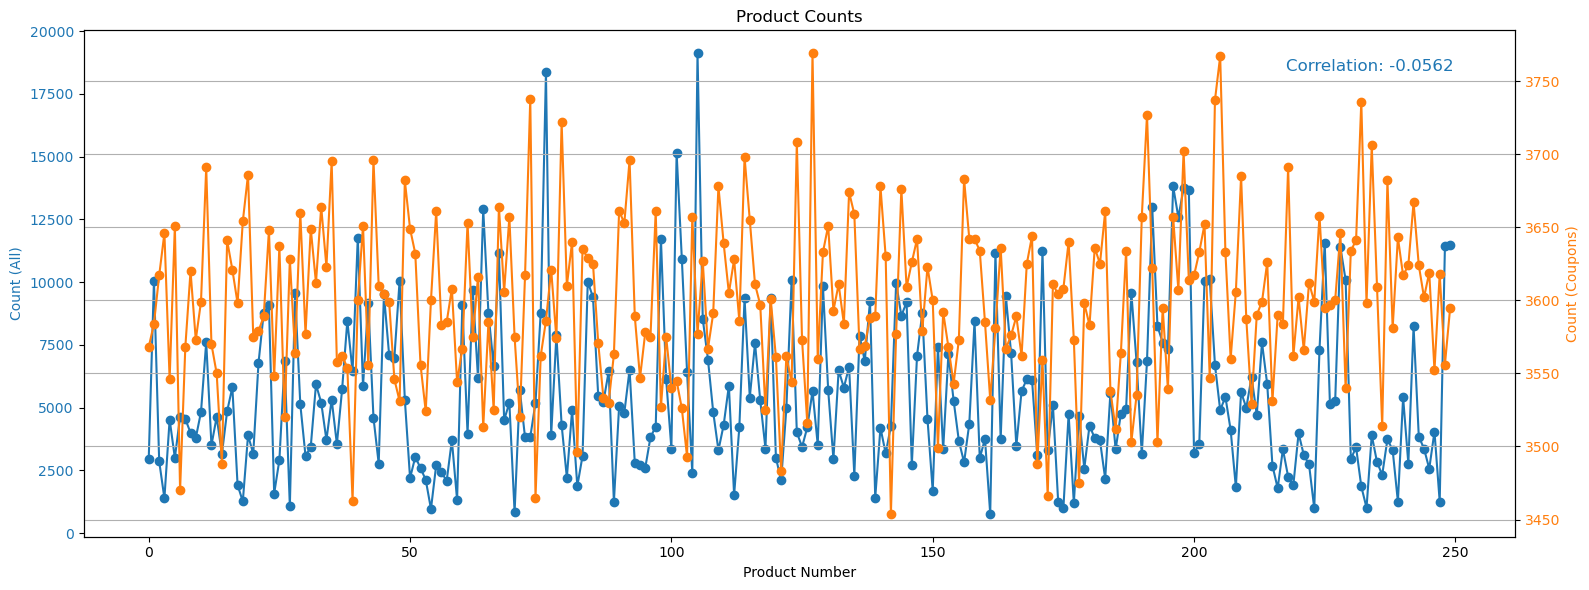

In [41]:
# Calculate the product counts for both datasets
product_counts = baskets['product'].value_counts().sort_index()
coupon_product_counts = coupons['product'].value_counts().sort_index()

# Calculate the correlation coefficient
correlation = np.corrcoef(product_counts, coupon_product_counts)[0, 1]

# Create the figure
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the entire dataset product counts on the primary y-axis
ax1.plot(product_counts.index, product_counts.values, marker='o', linestyle='-', label='Product Counts (All)')
ax1.set_xlabel('Product Number')
ax1.set_ylabel('Count (All)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the coupon product counts on the secondary y-axis
ax2.plot(coupon_product_counts.index, coupon_product_counts.values, marker='o', linestyle='-', color='tab:orange', label='Coupon Product Counts')
ax2.set_ylabel('Count (Coupons)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set titles and legend
plt.title('Product Counts')
fig.tight_layout()
plt.grid(True)

# Annotate the correlation coefficient at the bottom right
plt.annotate(f'Correlation: {correlation:.4f}', xy=(0.84, 0.92), xycoords='axes fraction', fontsize=12, color='tab:blue')


In [42]:
product_counts = baskets['product'].value_counts().sort_index()
coupon_product_counts = coupons['product'].value_counts().sort_index()

# Calculate the correlation coefficient
correlation = np.corrcoef(product_counts, coupon_product_counts)[0, 1]

print(f"Correlation Coefficient: {correlation:.4f}")

Correlation Coefficient: -0.0562


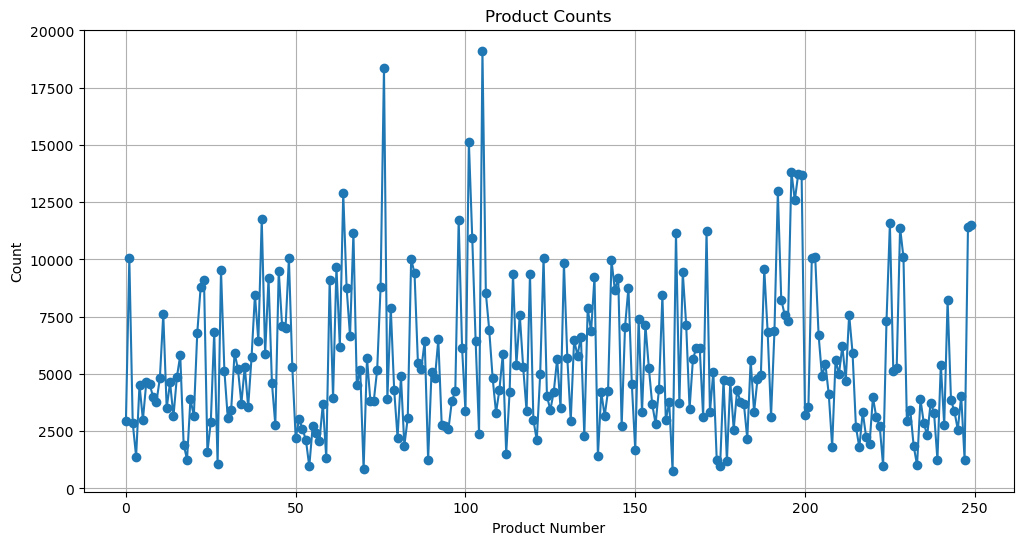

In [43]:
product_counts = baskets['product'].value_counts().sort_index()
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(product_counts.index, product_counts.values, marker='o', linestyle='-')
plt.xlabel('Product Number')
plt.ylabel('Count')
plt.title('Product Counts')
plt.grid(True)

In [44]:
#Get the average weekly spending for each individual customer and add the variable
average_weekly_spending = baskets.groupby('customer')['price_total'].mean().reset_index()
average_weekly_spending.rename(columns={'price_total': 'average_weekly_spending'}, inplace=True)
baskets = baskets.merge(average_weekly_spending, on='customer', how='left')

In [45]:
#Get the average weekly basket size and add the variable
# Calculate the average basket size per customer
basket_sizes = baskets.groupby(['customer', 'week']).size().reset_index(name='basket_size')
average_basket_size_per_customer = basket_sizes.groupby('customer')['basket_size'].mean().reset_index(name='average_basket_size')

# Merge the average basket size information back into the original DataFrame
baskets = baskets.merge(average_basket_size_per_customer, on='customer', how='left')


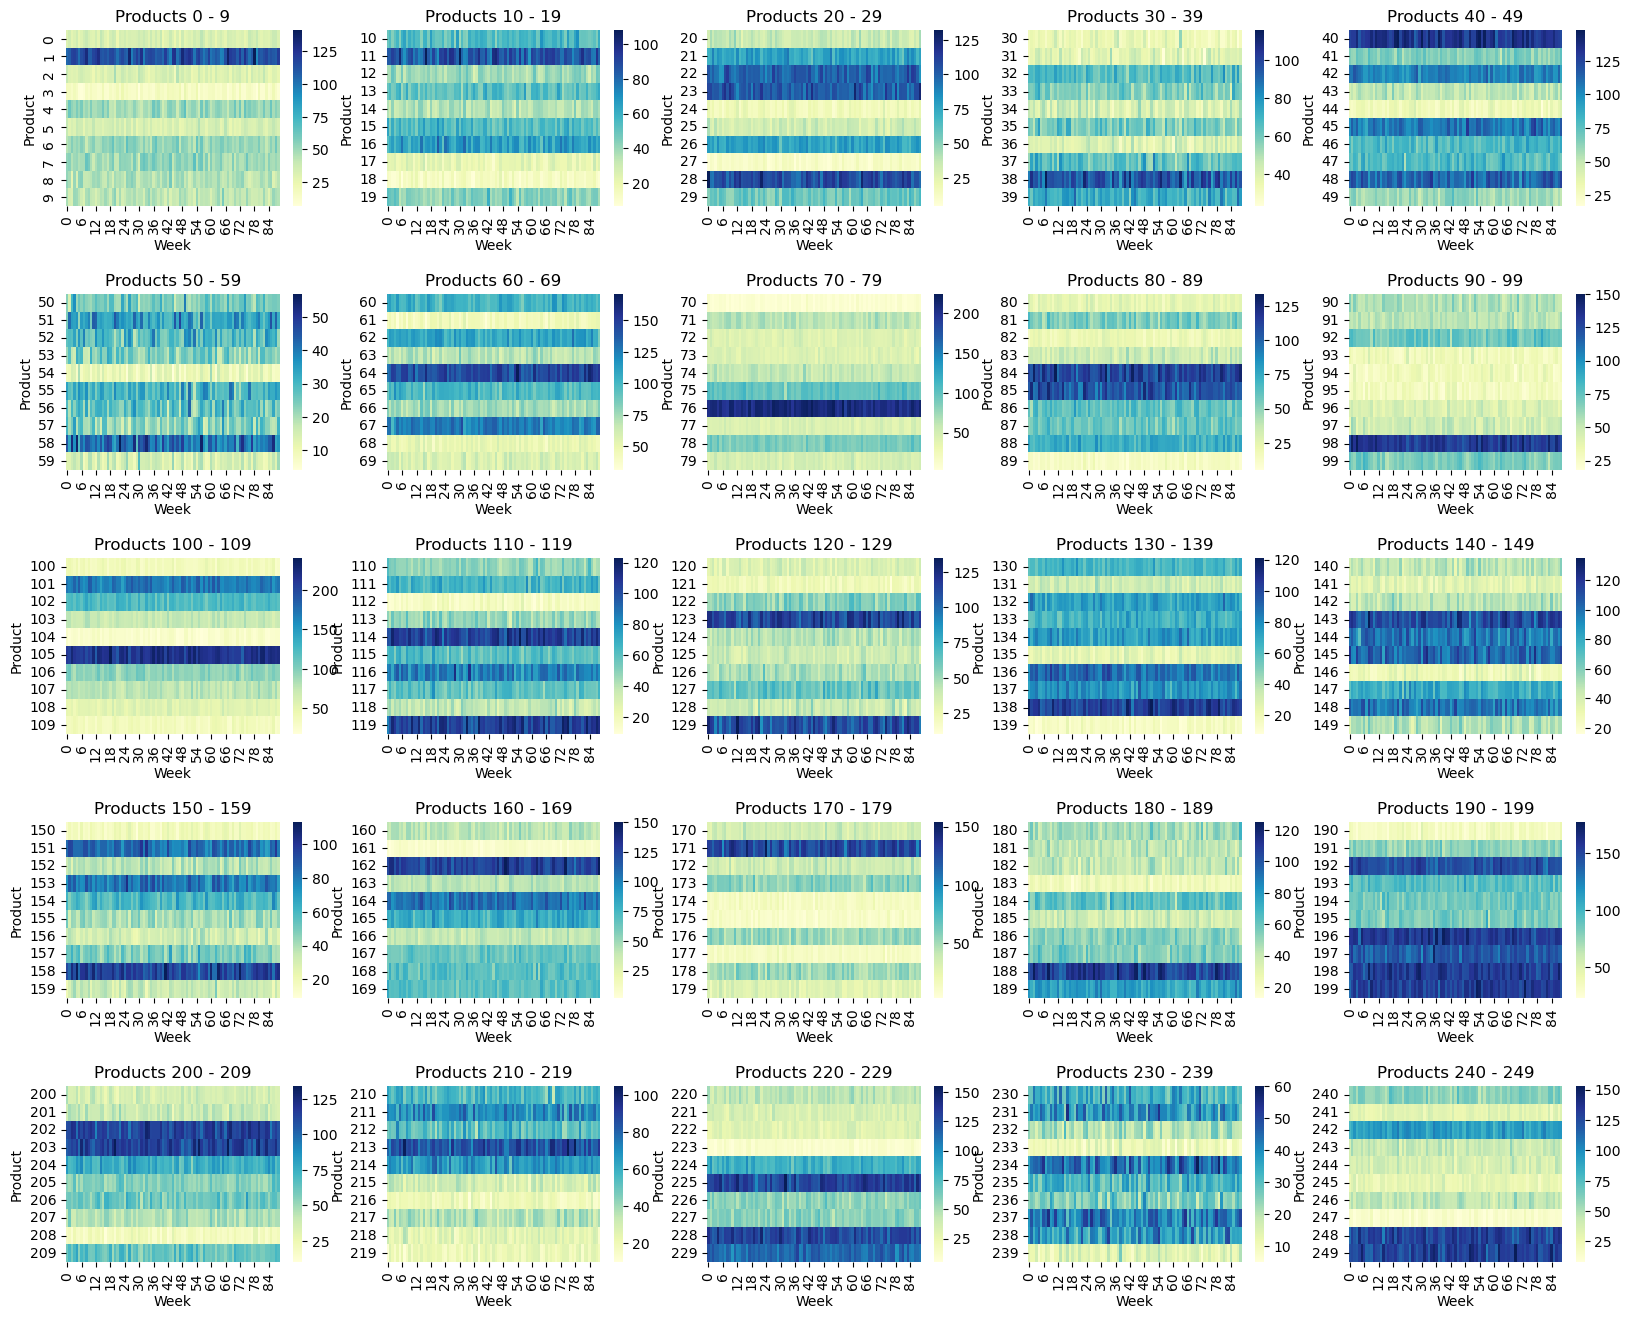

In [46]:
#Check for seasonality (doesn't really look like there is any)
product_groups = [baskets[baskets['product'].between(i * 10, (i + 1) * 10 - 1)] for i in range(25)]
fig, axs = plt.subplots(5, 5, figsize=(20, 16))
fig.subplots_adjust(hspace=0.5)

for i, product_group in enumerate(product_groups):
    row = i // 5
    col = i % 5

    product_weekly_frequencies = product_group.groupby(['product', 'week']).size().reset_index(name='count')

    pivot_table = product_weekly_frequencies.pivot(index='product', columns='week', values='count')

    sns.heatmap(pivot_table, cmap='YlGnBu', cbar=True, ax=axs[row, col])
    axs[row, col].set_title(f'Products {i * 10} - {(i + 1) * 10 - 1}')
    axs[row, col].set_xlabel('Week')
    axs[row, col].set_ylabel('Product')

for i in range(len(product_groups), 25):
    row = i // 5
    col = i % 5
    fig.delaxes(axs[row, col])

plt.show()


<Axes: xlabel='average_weekly_spending', ylabel='Count'>

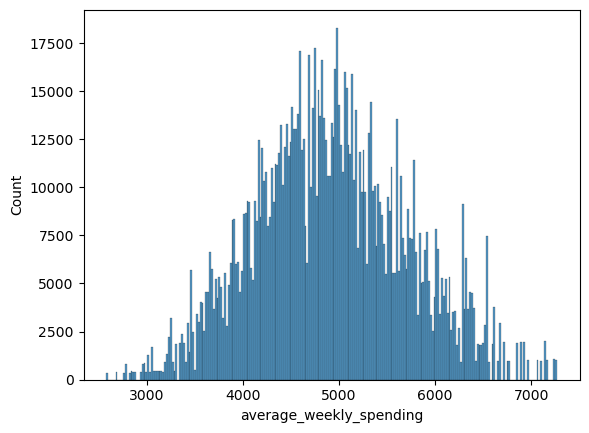

In [47]:
#Average spending distribution
sns.histplot(data=baskets, x="average_weekly_spending")

In [48]:
#Create product dataframe with each product, its price, and its frequency
product_df = pd.DataFrame(list(product_price_dict.items()), columns=['product', 'price'])
product_df.set_index('product', inplace=True)
product_freq_df = pd.DataFrame(baskets["product"].value_counts())
product_freq_df.rename(columns={'product': 'product_frequency'}, inplace=True)
product_freq_df.sort_index(inplace=True)
product_freq_list = product_freq_df["product_frequency"].to_list()
product_df["frequency"] = product_freq_list

<Axes: xlabel='frequency', ylabel='Count'>

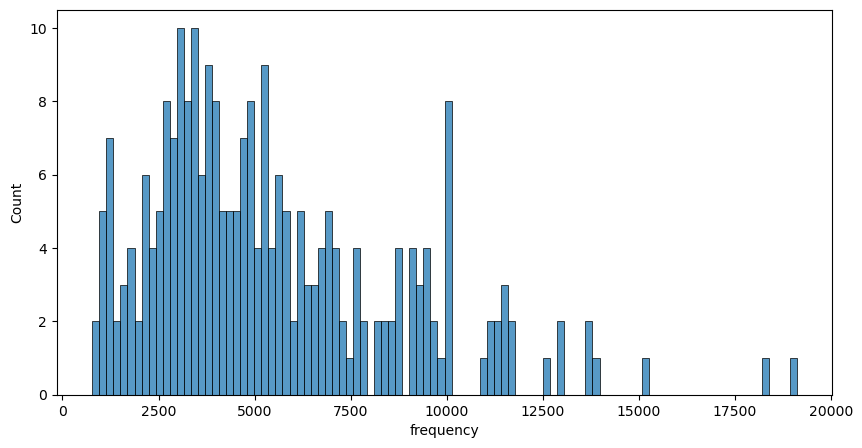

In [49]:
#Not very straightforward distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=product_df, x="frequency", bins=100)

<Axes: xlabel='price', ylabel='Count'>

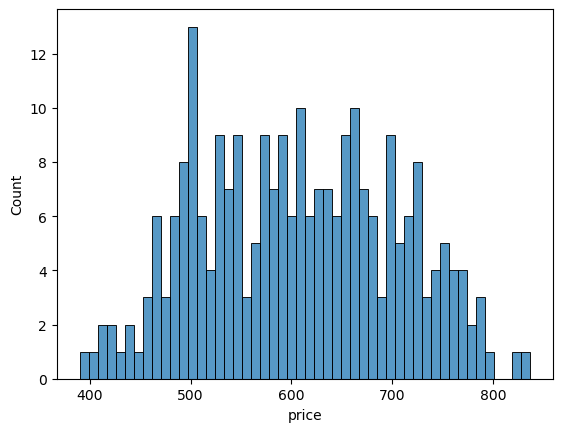

In [50]:
#Price distribution
sns.histplot(data=product_df, x="price", bins=50)

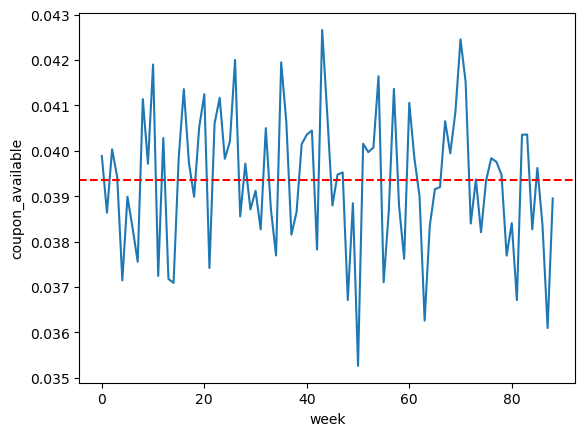

In [51]:
#Nothing really significant in terms of how often people are redeeming coupons over the weeks
sns.lineplot(data=baskets.groupby("week")["coupon_available"].mean())
plt.axhline(y=baskets.groupby("week")["coupon_available"].mean().mean(), color='red', linestyle='--', label='Mean Coupon Usage')

In [52]:
#Create percentage_of_purchases_on_discount which has the percentage of all purchases for each customer that used a coupon.

In [53]:
percentage_of_purchases_on_discount = baskets.groupby("customer")["coupon_available"].transform('mean')
baskets["percentage_of_purchases_on_discount"] = percentage_of_purchases_on_discount

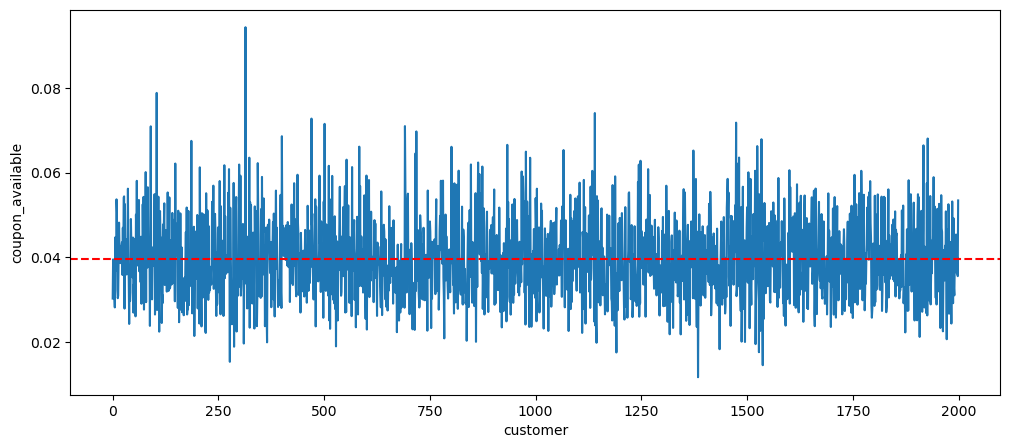

In [54]:
#Nothing really significant in terms of how often people are redeeming coupons between customers, one customer with largely above average usage
plt.figure(figsize=(12,5))
sns.lineplot(data=baskets.groupby("customer")["coupon_available"].mean())
plt.axhline(y=baskets.groupby("customer")["coupon_available"].mean().mean(), color='red', linestyle='--', label='Mean Coupon Usage')

In [55]:
print(f"Customer number {baskets.groupby('customer')['coupon_available'].mean().sort_values(ascending=False).index[0]} uses the most coupons")
baskets.groupby("customer")["coupon_available"].mean().sort_values(ascending=False)

Customer number 314 uses the most coupons


customer
314     0.094340
104     0.078829
1140    0.074074
470     0.072761
1474    0.071802
          ...   
1528    0.017595
1191    0.017525
277     0.015320
1537    0.014523
1384    0.011682
Name: coupon_available, Length: 2000, dtype: float64

In [56]:
# Create a copy of the 'baskets' DataFrame to avoid modifying the original data
baskets_copy = baskets.copy()

# Sort the copied DataFrame by 'customer', 'product_number', and 'week'
baskets_copy.sort_values(by=['customer', 'product', 'week'], inplace=True)

# Calculate the time difference (in weeks) between consecutive purchases for each customer and product
baskets_copy['time_diff_weeks'] = baskets_copy.groupby(['customer', 'product'])['week'].diff()

# Calculate the average time difference (in weeks) for each product
average_time_between_purchases = baskets_copy.groupby('product')['time_diff_weeks'].mean()

# Create a DataFrame with product numbers and their corresponding average times
average_time_df = pd.DataFrame({'product': average_time_between_purchases.index, 
                                'avg_time_between_purchases_weeks': average_time_between_purchases.values})

# Merge the average_time_df with products_df based on 'product_number'
product_df = product_df.merge(average_time_df, on='product', how='left')

# Display the updated products_df with the average time column
product_df


,product,price,frequency,avg_time_between_purchases_weeks
0,0,688,2949,5.948819
1,1,560,10051,4.443619
2,2,773,2866,6.383925
3,3,722,1391,10.592979
4,4,620,4526,6.471727
...,...,...,...,...
245,245,549,2566,8.446788
246,246,702,4048,5.520747
247,247,670,1256,8.550562
248,248,490,11433,4.667995


In [57]:
product_df.set_index('product', inplace=True)

In [58]:
product_df

,price,frequency,avg_time_between_purchases_weeks
product,,,
0,688,2949,5.948819
1,560,10051,4.443619
2,773,2866,6.383925
3,722,1391,10.592979
4,620,4526,6.471727
...,...,...,...
245,549,2566,8.446788
246,702,4048,5.520747
247,670,1256,8.550562


<Axes: xlabel='avg_time_between_purchases_weeks', ylabel='Count'>

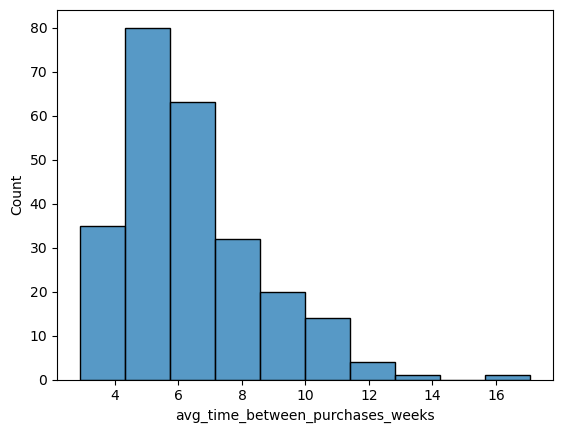

In [59]:
sns.histplot(product_df["avg_time_between_purchases_weeks"], bins=10)

<Axes: xlabel='frequency', ylabel='avg_time_between_purchases_weeks'>

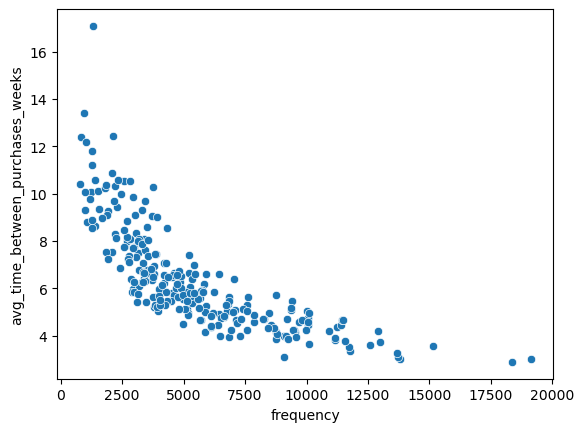

In [60]:
sns.scatterplot(data=product_df, x="frequency", y="avg_time_between_purchases_weeks")

<Axes: >

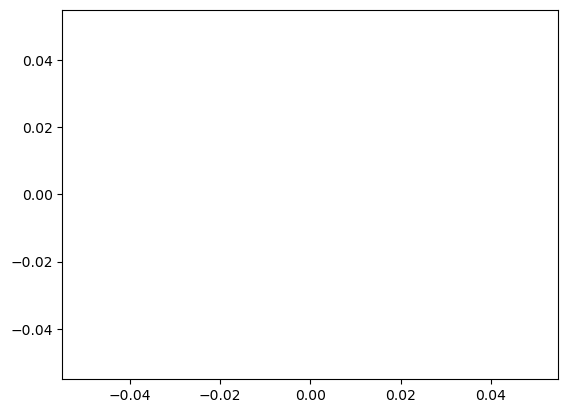

In [61]:
sns.histplot()

In [62]:
baskets_validation

,week,customer,product,price
68076681,89,0,67,637
68076682,89,0,71,629
68076683,89,0,91,453
68076684,89,0,123,483
68076685,89,0,167,582
...,...,...,...,...
68091869,89,1999,144,562
68091870,89,1999,158,566
68091871,89,1999,192,549
68091872,89,1999,213,592


In [63]:
baskets

,week,customer,product,price,price_total,coupon_available,average_weekly_spending,average_basket_size,percentage_of_purchases_on_discount
0,0,0,71,629,5908,0,5271.600000,8.539326,0.030263
1,0,0,91,605,5908,0,5271.600000,8.539326,0.030263
2,0,0,116,715,5908,0,5271.600000,8.539326,0.030263
3,0,0,123,483,5908,0,5271.600000,8.539326,0.030263
4,0,0,157,592,5908,0,5271.600000,8.539326,0.030263
...,...,...,...,...,...,...,...,...,...
1363522,88,1999,144,562,4712,0,5300.245547,8.831461,0.053435
1363523,88,1999,158,566,4712,0,5300.245547,8.831461,0.053435
1363524,88,1999,168,588,4712,0,5300.245547,8.831461,0.053435
1363525,88,1999,170,615,4712,0,5300.245547,8.831461,0.053435


In [64]:
baskets_full = baskets_full.merge(product_df['avg_time_between_purchases_weeks'], left_on='product', right_index=True, how='left')

#Here I am getting the last week that a specific customer bought a specific item (relative to their current week)
baskets_sorted = baskets_full.sort_values(by=['week', 'customer', 'product']).copy()

# Find the last week each product was bought by the same customer before the current entry
baskets_sorted['last_week_bought'] = baskets_sorted.groupby(['customer', 'product'])['week'].shift(1)

# Fill missing values (for the first purchase of each product) with 0
baskets_sorted['last_week_bought'].fillna(0, inplace=True)

# Add the 'last_week_bought' column to the original 'baskets' DataFrame
baskets_full['last_week_bought'] = baskets_sorted['last_week_bought']

baskets_full["weeks_since_last_purchase"] = baskets_full["week"] - baskets_full["last_week_bought"]

baskets_full["difference_avg_weeks"] = baskets_full["avg_time_between_purchases_weeks"] - baskets_full["weeks_since_last_purchase"]

columns_to_concat = ['avg_time_between_purchases_weeks', 'last_week_bought', 'weeks_since_last_purchase', 'difference_avg_weeks']

columns_to_concat = ['avg_time_between_purchases_weeks', 'last_week_bought', 'weeks_since_last_purchase', 'difference_avg_weeks']

# Merge the selected columns into the baskets DataFrame for weeks 0-88
baskets = baskets.merge(baskets_full[(baskets_full['week'] != 89)][['customer', 'week', 'product', 'avg_time_between_purchases_weeks', 'last_week_bought', 'weeks_since_last_purchase', 'difference_avg_weeks']],
                        on=['customer', 'week', 'product'], 
                        how='left')

# Merge the selected columns into the baskets_validation DataFrame for week 89
baskets_validation = baskets_validation.merge(baskets_full[(baskets_full['week'] == 89)][['customer', 'week', 'product', 'avg_time_between_purchases_weeks', 'last_week_bought', 'weeks_since_last_purchase', 'difference_avg_weeks']],
                                                on=['customer', 'week', 'product'], 
                                                how='left')


In [65]:
baskets_validation

,week,customer,product,price,avg_time_between_purchases_weeks,last_week_bought,weeks_since_last_purchase,difference_avg_weeks
0,89,0,67,637,3.820062,88.0,1.0,2.820062
1,89,0,71,629,5.899321,87.0,2.0,3.899321
2,89,0,91,453,5.127378,88.0,1.0,4.127378
3,89,0,123,483,4.742331,83.0,6.0,-1.257669
4,89,0,167,582,4.671459,84.0,5.0,-0.328541
...,...,...,...,...,...,...,...,...
15188,89,1999,144,562,4.305881,88.0,1.0,3.305881
15189,89,1999,158,566,4.339318,88.0,1.0,3.339318
15190,89,1999,192,549,3.736633,88.0,1.0,2.736633
15191,89,1999,213,592,5.051823,84.0,5.0,0.051823


In [66]:
baskets

,week,customer,product,price,price_total,coupon_available,average_weekly_spending,average_basket_size,percentage_of_purchases_on_discount,avg_time_between_purchases_weeks,last_week_bought,weeks_since_last_purchase,difference_avg_weeks
0,0,0,71,629,5908,0,5271.600000,8.539326,0.030263,5.899321,0.0,0.0,5.899321
1,0,0,91,605,5908,0,5271.600000,8.539326,0.030263,5.127378,0.0,0.0,5.127378
2,0,0,116,715,5908,0,5271.600000,8.539326,0.030263,5.304437,0.0,0.0,5.304437
3,0,0,123,483,5908,0,5271.600000,8.539326,0.030263,4.742331,0.0,0.0,4.742331
4,0,0,157,592,5908,0,5271.600000,8.539326,0.030263,6.471301,0.0,0.0,6.471301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363522,88,1999,144,562,4712,0,5300.245547,8.831461,0.053435,4.305881,85.0,3.0,1.305881
1363523,88,1999,158,566,4712,0,5300.245547,8.831461,0.053435,4.339318,87.0,1.0,3.339318
1363524,88,1999,168,588,4712,0,5300.245547,8.831461,0.053435,4.841747,87.0,1.0,3.841747
1363525,88,1999,170,615,4712,0,5300.245547,8.831461,0.053435,8.013720,3.0,85.0,-76.986280


<Axes: xlabel='difference_avg_weeks', ylabel='Count'>

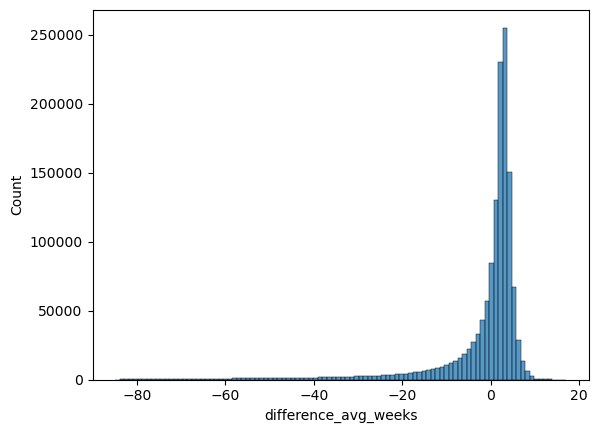

In [67]:
#Heavily affected by outliars as some people never buy certain products
sns.histplot(data=baskets, x="difference_avg_weeks", bins=100)

In [68]:
baskets["difference_avg_weeks"].sort_values().head(30)

1363244   -84.995272
1354193   -84.995272
1357579   -84.995272
1350932   -84.970845
1359717   -84.970845
1358190   -84.725317
1354577   -84.631617
1359190   -84.631617
1361544   -84.466933
1351969   -84.466933
1359284   -84.466933
1361091   -84.420058
1351943   -84.263367
1362772   -84.263367
1358263   -84.263367
1355766   -84.263367
1359867   -84.232543
1355291   -84.232543
1355718   -84.232543
1363089   -84.179938
1348622   -84.164377
1352682   -84.164377
1358196   -84.164377
1340632   -84.112885
1334239   -84.112885
1360598   -84.090440
1354680   -84.090440
1361477   -84.072979
1351958   -84.072979
1362590   -84.072979
Name: difference_avg_weeks, dtype: float64

In [69]:
#The percentage of weeks in which a specific customer purchased a specific product
baskets['product_week_percentage'] = baskets.groupby(['customer', 'product'])['week'].transform('nunique') / 89

In [70]:
#Customers that buy a specific product every single week
uni_prod = baskets[baskets["product_week_percentage"] == 1]["product"].unique()
uni_cus = baskets[baskets["product_week_percentage"] == 1]["customer"].unique()
uni_dict = {uni_cus[i] : uni_prod[i] for i in range(len(uni_prod))}
uni_dict

{346: 229, 520: 60, 1159: 199, 1827: 75}

In [71]:
for customer, product in uni_dict.items():
    print(f"Customer {customer} bought product {product} every single week.")

Customer 346 bought product 229 every single week.
Customer 520 bought product 60 every single week.
Customer 1159 bought product 199 every single week.
Customer 1827 bought product 75 every single week.


<Axes: xlabel='product_week_percentage', ylabel='Count'>

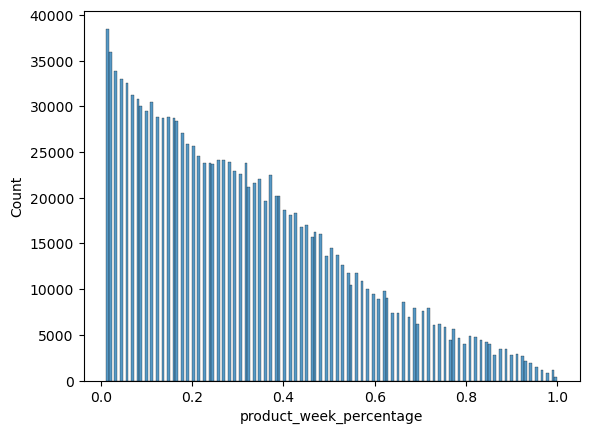

In [72]:
sns.histplot(data=baskets, x="product_week_percentage")

In [73]:
baskets["product_week_percentage"].value_counts()

0.011236    38517
0.022472    35900
0.033708    33927
0.044944    32996
0.056180    32560
            ...  
0.955056     1530
0.988764     1144
0.966292     1118
0.977528      870
1.000000      445
Name: product_week_percentage, Length: 89, dtype: int64

# Creating train and test tables

In [74]:
customer_df = baskets.groupby('customer').agg({
    'average_weekly_spending': 'first',  # You can use 'first' to select the first value for each customer
    'average_basket_size': 'first'  # You can use 'first' to select the first value for each customer
}).reset_index()

# Rename the columns as needed


# Set the customer IDs as the index
customer_df.set_index('customer', inplace=True)

# Now, customer_df contains customer-specific information
customer_df.head()


,average_weekly_spending,average_basket_size
customer,,
0,5271.600000,8.539326
1,4688.034954,7.393258
2,3745.693050,5.820225
3,4983.412399,8.337079
4,3886.810565,6.168539


<Axes: xlabel='average_weekly_spending', ylabel='Count'>

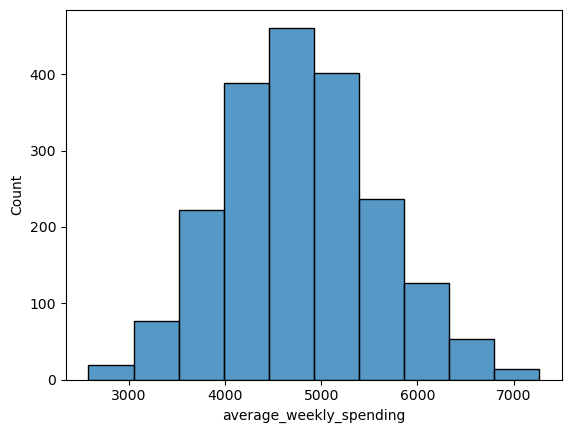

In [75]:
sns.histplot(customer_df["average_weekly_spending"], bins=10)

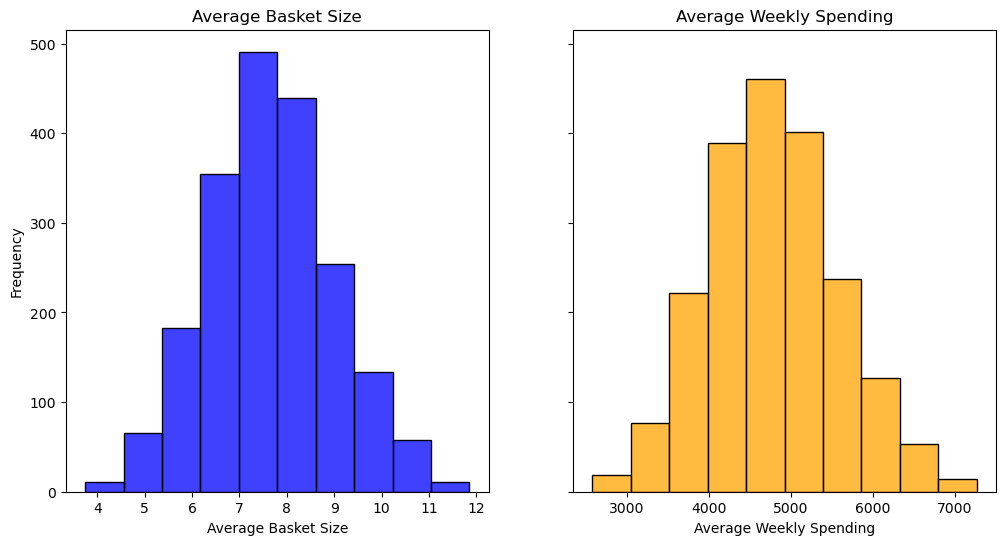

In [76]:
# Create subplots with shared y-axes
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

# Plot histograms for average basket size and average spending in separate subplots
sns.histplot(customer_df["average_basket_size"], bins=10, color='blue', ax=axes[0])
axes[0].set_xlabel("Average Basket Size")
axes[0].set_title("Average Basket Size")

sns.histplot(customer_df["average_weekly_spending"], bins=10, color='orange', ax=axes[1])
axes[1].set_xlabel("Average Weekly Spending")
axes[1].set_title("Average Weekly Spending")

# Set a common y-axis label
axes[0].set_ylabel("Frequency")

# Show the subplots
plt.show()


In [77]:
# Create a DataFrame with product_week_percentage
customer_product_week_percentage_df = baskets[['customer', 'product', 'product_week_percentage']]

# Group by customer and product to calculate the mean product_week_percentage
customer_product_week_percentage_df = customer_product_week_percentage_df.groupby(['customer', 'product']).mean().reset_index()

# Pivot the DataFrame to have customers as rows and products as columns
customer_product_week_percentage_pivot = customer_product_week_percentage_df.pivot_table(index='customer', columns='product', values='product_week_percentage', fill_value=0)

# Display the resulting DataFrame
customer_product_week_percentage_pivot


product,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.0,0.089888,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.101124,0.000000,0.000000,0.000000,0.011236,0.044944,0.0,0.000000,0.000000,0.0,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.011236,0.056180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,0.000000,0.022472,0.000000,0.000000,0.000000,0.101124,0.000000,0.000000,0.000000,0.033708,0.0,0.000000,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.382022,0.000000,0.00000,0.000000,0.741573,0.000000,0.000000,0.000000,0.000000,0.191011,0.0,0.000000,0.022472,0.022472,0.033708,0.000000,0.000000,0.000000,0.000000,0.000000,0.247191,0.000000,0.0,0.000000,0.808989,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.022472,0.000000,0.022472,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.067416,0.000000,0.000000,0.00000,0.000000,0.000000,0.337079,0.000000,0.000000,0.011236,0.000000,0.000000,0.011236,0.471910,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.685393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,0.000000,0.056180,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.337079,0.000000,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,0.000000,0.000000,0.348315,0.000000,0.000000,0.000000,0.325843,0.022472,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.078652,0.000000,0.033708,0.000000,0.000000,0.573034,0.011236,0.000000,0.000000,0.000000,0.000000,0.0,0.101124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.438202,0.000000,0.000000,0.000000,0.000000,0.067416,0.000000,0.000000,0.123596,0.123596,0.000000,0.000000,0.112360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.011236,0.752809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011236,0.0,0.000000,0.000000,0.0,0.000000,0.146067,0.0,0.011236,0.0,0.000000,0.011236,0.078652,0.000000,0.000000,0.000000,0.000000,0.146067
1,0.067416,0.146067,0.000000,0.0,0.101124,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.011236,0.000000,0.000000,0.000000,0.000000,0.022472,0.0,0.011236,0.000000,0.0,0.404494,0.359551,0.000000,0.000000,0.000000,0.000000,0.000000,0.044944,0.000000,0.000000,0.022472,0.000000,0.067416,0.0,0.067416,0.056180,0.022472,0.011236,0.101124,0.000000,0.000000,0.101124,0.000000,0.000000,0.000000,0.000000,0.000000,0.191011,0.000000,0.123596,0.000000,0.000000,0.067416,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.505618,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.011236,0.011236,0.022472,0.0,0.606742,0.000000,0.000000,0.000000,0.000000,0.303371,0

In [78]:
# Add a variable that represents the product that is most frequently ordered with a given product. Finding their complimentary pair
# Group by week and customer to get each basket
grouped = baskets.groupby(['week', 'customer'])

# Initialize a Counter for product pairs
product_pair_counts = Counter()

# Count product pairs in each basket
for name, group in grouped:
    products = group['product'].tolist()
    for i in range(len(products)):
        for j in range(i+1, len(products)):
            product_pair = tuple(sorted([products[i], products[j]]))
            product_pair_counts[product_pair] += 1

# Identify most frequently purchased accompanying product for each product
most_frequent_pairs = {}
for (product1, product2), count in product_pair_counts.items():
    if product1 not in most_frequent_pairs or most_frequent_pairs[product1][1] < count:
        most_frequent_pairs[product1] = (product2, count)
    if product2 not in most_frequent_pairs or most_frequent_pairs[product2][1] < count:
        most_frequent_pairs[product2] = (product1, count)

# Create a new column 'most_frequent_pair' in the product_df DataFrame
product_df['most_frequent_pair'] = product_df.index.map(lambda x: most_frequent_pairs.get(x, (None, 0))[0])


In [79]:
product_df_cluster = product_df.drop("most_frequent_pair", axis=1)
product_df_cluster
product_info_standardized = scaler.fit_transform(product_df_cluster)
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(product_info_standardized)
df_product_kmeans = product_df_cluster.copy()
df_product_kmeans['K-means Clusters'] = kmeans.labels_
df_segm_analysis = df_product_kmeans.groupby(['K-means Clusters']).mean()
product_df['cluster'] = kmeans.labels_
df_segm_analysis

/Users/alex/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,price,frequency,avg_time_between_purchases_weeks
K-means Clusters,,,
0,547.528571,9560.628571,4.396269
1,663.769231,1966.435897,9.876662
2,693.301205,4687.469880,5.824774
3,515.706897,3940.206897,7.225296


<Axes: xlabel='cluster', ylabel='count'>

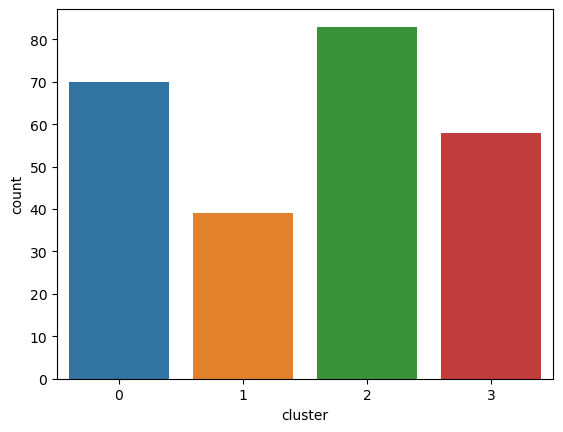

In [80]:
sns.countplot(data=product_df, x="cluster")

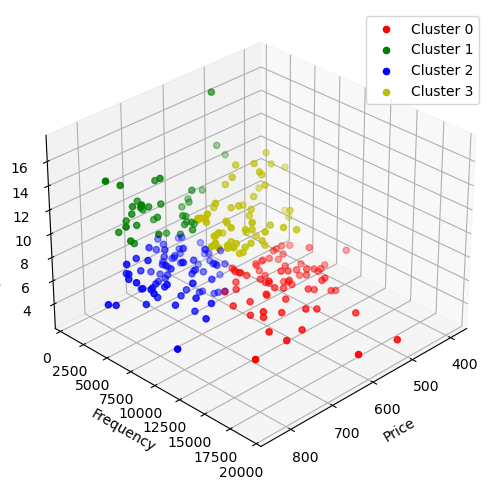

In [81]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y']

for i in range(4):  # Assuming 4 clusters
    cluster_data = df_product_kmeans[df_product_kmeans['K-means Clusters'] == i]
    ax.scatter(cluster_data['price'], cluster_data['frequency'], cluster_data['avg_time_between_purchases_weeks'], c=colors[i], label=f'Cluster {i}')

ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
ax.set_zlabel('Coupon Available')
ax.view_init(elev=30, azim=45, roll=0)  # Adjust the elevation and azimuth angles
plt.legend()

plt.show()

In [82]:
def target_df(weeks):
    df = pd.DataFrame()
    for week in weeks:
        baseline_target = build_target(baskets_full, week)
        df = df.append(baseline_target, ignore_index=True)
        
    df["price"] = df["product"].apply(lambda x: product_df.iloc[x].price)
    df["average_weekly_spending"] = df["customer"].apply(lambda x: customer_df.iloc[x].average_weekly_spending)
    df["average_basket_size"] = df["customer"].apply(lambda x: customer_df.iloc[x].average_basket_size)
    df = df.merge(customer_product_week_percentage_pivot.stack().reset_index(name='product_week_percentage'), on=['customer', 'product'], how='left')
    df["avg_time_between_purchases_weeks"] = df["product"].apply(lambda x: product_df.iloc[x].avg_time_between_purchases_weeks)
    df["total_product_frequency"] = df["product"].apply(lambda x: product_df.iloc[x].frequency)
    df["product_cluster"] = df["product"].apply(lambda x: product_df.iloc[x].cluster)
    
    
    return df


In [83]:
baseline_target = target_df([89])

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_24616/788664116.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(baseline_target, ignore_index=True)


In [84]:
baseline_target

,week,customer,product,y,price,average_weekly_spending,average_basket_size,product_week_percentage,avg_time_between_purchases_weeks,total_product_frequency,product_cluster
0,89,0,0,0,688.0,5271.600000,8.539326,0.000000,5.948819,2949.0,2.0
1,89,0,1,0,560.0,5271.600000,8.539326,0.000000,4.443619,10051.0,0.0
2,89,0,2,0,773.0,5271.600000,8.539326,0.000000,6.383925,2866.0,2.0
3,89,0,3,0,722.0,5271.600000,8.539326,0.000000,10.592979,1391.0,1.0
4,89,0,4,0,620.0,5271.600000,8.539326,0.089888,6.471727,4526.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
499995,89,1999,245,1,549.0,5300.245547,8.831461,0.123596,8.446788,2566.0,3.0
499996,89,1999,246,0,702.0,5300.245547,8.831461,0.000000,5.520747,4048.0,2.0
499997,89,1999,247,0,670.0,5300.245547,8.831461,0.000000,8.550562,1256.0,1.0
499998,89,1999,248,0,490.0,5300.245547,8.831461,0.000000,4.667995,11433.0,0.0


In [85]:
baseline_target.y.value_counts()

0    484807
1     15193
Name: y, dtype: int64

In [86]:
def train_df(weeks):
    df = pd.DataFrame()
    for week in weeks:
        baseline_target_train = build_target(baskets, week)
        df = df.append(baseline_target_train, ignore_index=True)
        
    df["price"] = df["product"].apply(lambda x: product_df.iloc[x].price)
    df["average_weekly_spending"] = df["customer"].apply(lambda x: customer_df.iloc[x].average_weekly_spending)
    df["average_basket_size"] = df["customer"].apply(lambda x: customer_df.iloc[x].average_basket_size)
    df = df.merge(customer_product_week_percentage_pivot.stack().reset_index(name='product_week_percentage'), on=['customer', 'product'], how='left')
    df["avg_time_between_purchases_weeks"] = df["product"].apply(lambda x: product_df.iloc[x].avg_time_between_purchases_weeks)
    df["total_product_frequency"] = df["product"].apply(lambda x: product_df.iloc[x].frequency)
    df["product_cluster"] = df["product"].apply(lambda x: product_df.iloc[x].cluster)
    
    return df

        
    

In [87]:
baseline_target_train = train_df([84, 85, 86, 87, 88])

/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_24616/2777037053.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(baseline_target_train, ignore_index=True)
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_24616/2777037053.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(baseline_target_train, ignore_index=True)
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_24616/2777037053.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(baseline_target_train, ignore_index=True)
/var/folders/4z/llvfppw90ydchwbr1fv8xb0m0000gn/T/ipykernel_24616/2777037053.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

In [88]:
baseline_target_train.shape

(2500000, 11)

In [89]:
baseline_target_train.y.value_counts()

0    2423364
1      76636
Name: y, dtype: int64

In [90]:
product_df

,price,frequency,avg_time_between_purchases_weeks,most_frequent_pair,cluster
product,,,,,
0,688,2949,5.948819,60,2
1,560,10051,4.443619,22,0
2,773,2866,6.383925,76,2
3,722,1391,10.592979,105,1
4,620,4526,6.471727,76,2
...,...,...,...,...,...
245,549,2566,8.446788,164,3
246,702,4048,5.520747,197,2
247,670,1256,8.550562,194,1


In [91]:
# def build_base_table(baskets, week):
#     # target variable (product purchase)
#     # consider using multiple weeks for training! more data might lead to better results.
#     # also, different weeks might have different information.
#     y = build_target(baskets, week)
#     # features
#     # note how features are computed on data BEFORE the target week
#     x_1 = build_frequency_feature(baskets, -1, week - 1, "frequency_full")
#     x_2 = build_frequency_feature(baskets, week - 30, week - 1, "frequency_l30")
#     x_3 = build_frequency_feature(baskets, week - 5, week - 1, "frequency_l5")
#     base_table_yx = (
#         y.merge(x_1, on=["customer", "product"], how="left")
#         .merge(x_2, on=["customer", "product"], how="left")
#         .merge(x_3, on=["customer", "product"], how="left")
#         .fillna(0)
#     )
#     return base_table_yx

Optimization terminated successfully.
         Current function value: 0.087586
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              2500000
Model:                          Logit   Df Residuals:                  2499993
Method:                           MLE   Df Model:                            6
Date:                Wed, 25 Oct 2023   Pseudo R-squ.:                  0.3607
Time:                        19:24:04   Log-Likelihood:            -2.1897e+05
converged:                       True   LL-Null:                   -3.4252e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -4.1538      0.058    -71.78

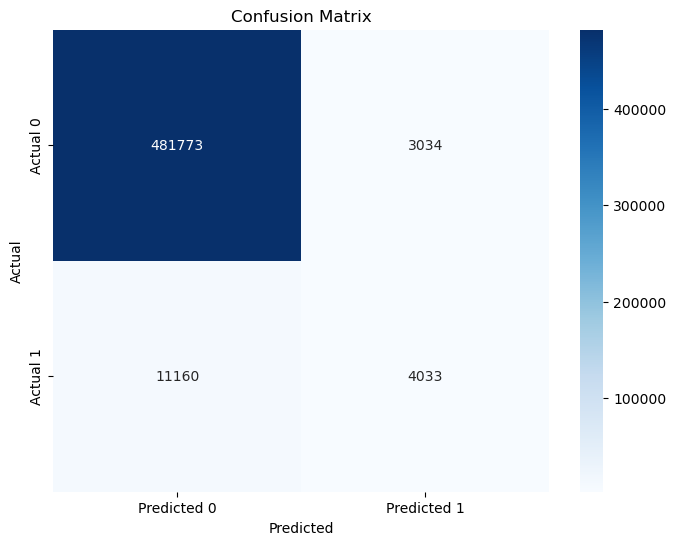

In [92]:
import statsmodels.api as sm
X_train = baseline_target_train.drop(['y', 'week', 'product_cluster', 'product', 'customer'], axis=1)
y_train = baseline_target_train['y']
X_test = baseline_target.drop(['y', 'week', 'product_cluster', 'product', 'customer'], axis=1)
y_test = baseline_target['y']
# Add a constant (intercept) to the independent variables
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Create and fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the model summary
print(result.summary())

# Make predictions on the test data
y_pred = result.predict(X_test)

# Convert predicted probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

print(classification_report(y_test, y_pred_binary))

# Calculate log loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss:.4f}")


Log Loss: 0.0773


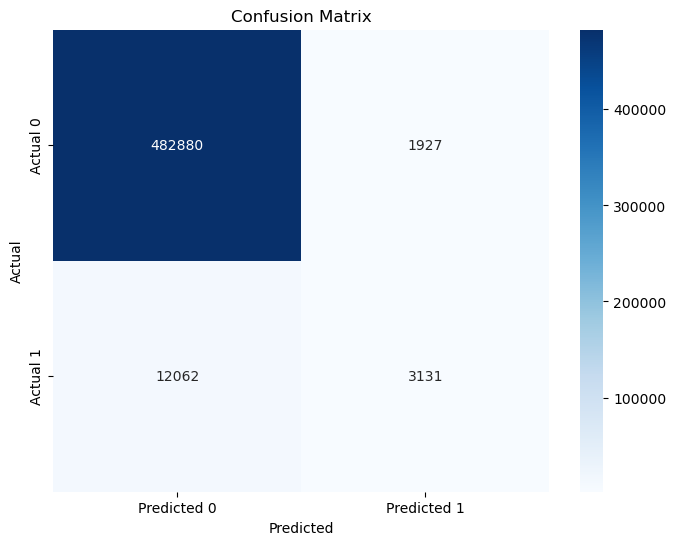

Feature importances: [3.49322084e-04 1.19916282e-03 3.42683621e-04 7.12859926e-04
 7.52461863e-04 8.88098168e-04 9.94750767e-01 4.68119744e-04
 5.36524831e-04 0.00000000e+00]


In [93]:
# Create a Gradient Boosting Classifier
X_train = baseline_target_train.drop(['y'], axis=1)
y_train = baseline_target_train['y']
X_test = baseline_target.drop(['y'], axis=1)
y_test = baseline_target['y']
gb = GradientBoostingClassifier(learning_rate=0.22865308252444408, max_depth=5, n_estimators=15, subsample=0.9, random_state=42) #to be updated
gb.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = gb.predict_proba(X_test)[:, 1]

# Round probabilities to get binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate the log loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Gradient Boosting also provides feature importances
feature_importances = gb.feature_importances_
print("Feature importances:", feature_importances)

Best parameters:
[0.17929337015611813, 5, 16, 0.9]
Best score (log loss):
0.07725377694079755


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

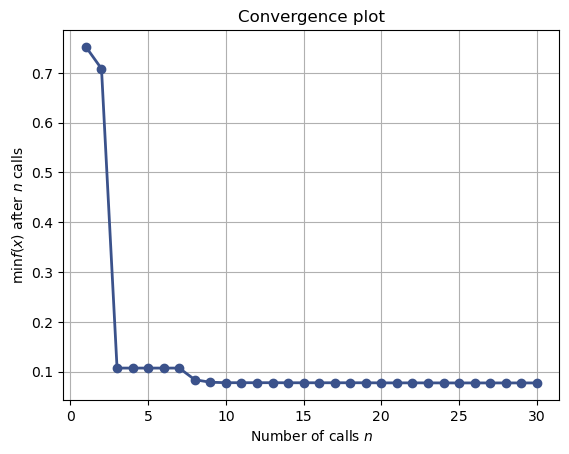

In [94]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
# Define the hyperparameter search space for Gradient Boosting
space = [
    Real(0.1, 1, name='learning_rate'),
    Integer(1, 5, name='max_depth'),
    Integer(1, 25, name='n_estimators'),
    Real(0.1, 0.9, name='subsample')
]

# Define the objective function for optimization
@use_named_args(space)
def objective(**params):
    clf = GradientBoostingClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)  # Train the model on your training data
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Predict probabilities on the test data
    return log_loss(y_test, y_pred_proba)

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# Print the results
print("Best parameters:")
print(res_gp.x)

print("Best score (log loss):")
print(res_gp.fun)

# Plot convergence (you'll need to import plot_convergence from skopt.plots)
from skopt.plots import plot_convergence
plot_convergence(res_gp)

Log Loss: 0.0863


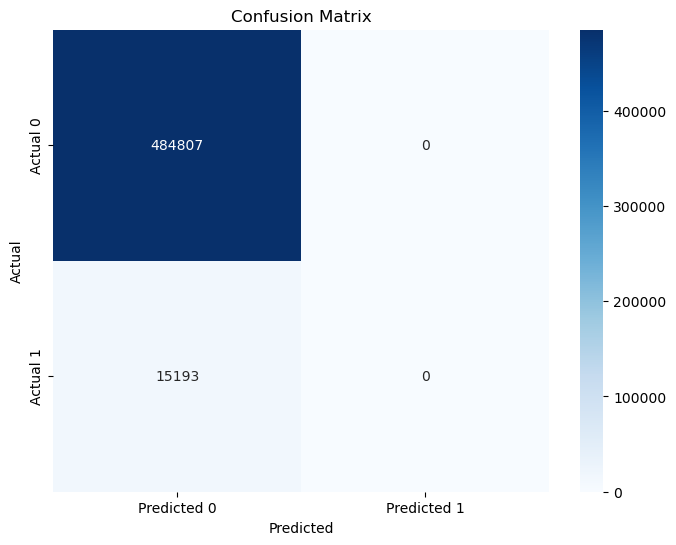

Feature importances: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [95]:
# Create a Ada Boosting Classifier
X_train = baseline_target_train.drop(['y'], axis=1)
y_train = baseline_target_train['y']
X_test = baseline_target.drop(['y'], axis=1)
y_test = baseline_target['y']
ada = AdaBoostClassifier(learning_rate=0.1, n_estimators=6, random_state=42) #to be updated
ada.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = ada.predict_proba(X_test)[:, 1]

# Round probabilities to get binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate the log loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Gradient Boosting also provides feature importances
feature_importances = ada.feature_importances_
print("Feature importances:", feature_importances)

Best parameters:
[0.1, 6]
Best score (log loss):
0.08628028288566114


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

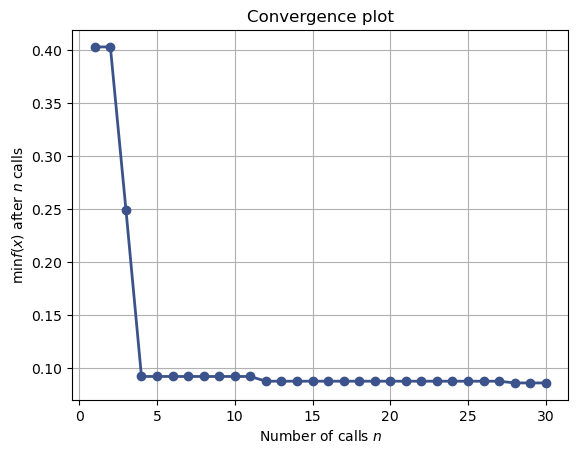

In [96]:
# Define the hyperparameter search space for AdaBoost
space = [
    Real(0.1, 1, name='learning_rate'),
    Integer(1, 50, name='n_estimators')
]

# Define the objective function for optimization
@use_named_args(space)
def objective(**params):
    clf = AdaBoostClassifier(**params, random_state=42)
    clf.fit(X_train, y_train)  # Train the model on your training data
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Predict probabilities on the test data
    return log_loss(y_test, y_pred_proba)

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# Print the results
print("Best parameters:")
print(res_gp.x)

print("Best score (log loss):")
print(res_gp.fun)

# Plot convergence (you'll need to import plot_convergence from skopt.plots)
plot_convergence(res_gp)

Log Loss: 0.0773
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    484807
           1       0.62      0.21      0.31     15193

    accuracy                           0.97    500000
   macro avg       0.80      0.60      0.65    500000
weighted avg       0.96      0.97      0.97    500000



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

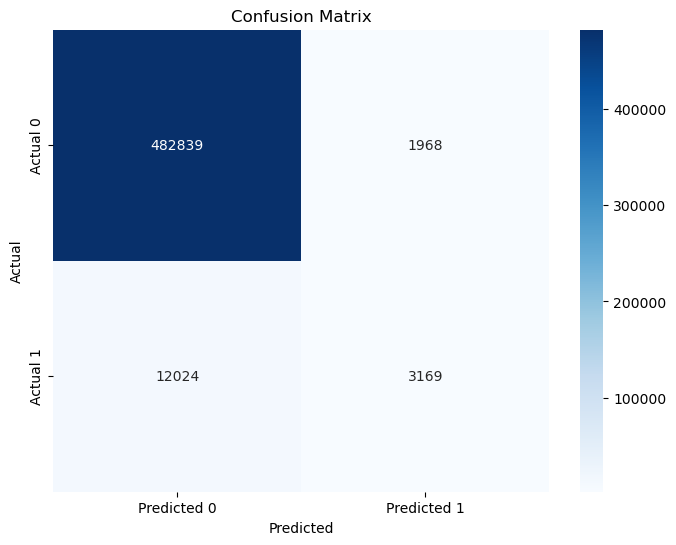

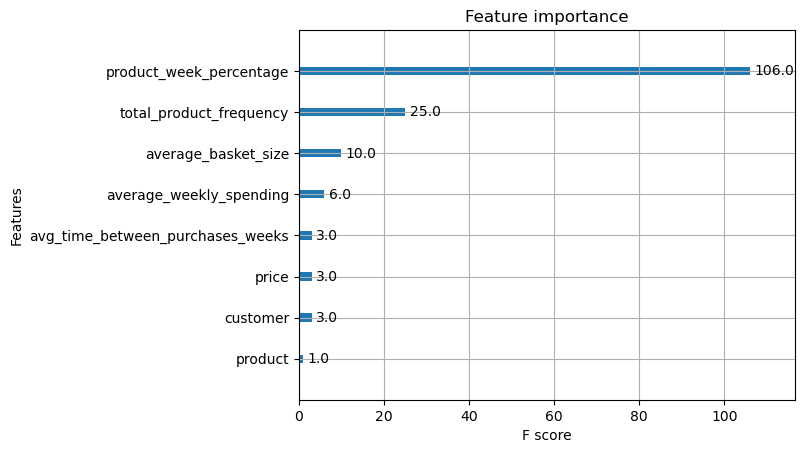

In [102]:
X_train = baseline_target_train.drop(['y'], axis=1)
y_train = baseline_target_train['y']
X_test = baseline_target.drop(['y'], axis=1)
y_test = baseline_target['y']
# [0.26725841546678447, 3, 28, 0.3335361238930648, 0.6077918497121169, 0.7280643438752412] = [learning_rate_, max_depth_, n_estimators_, gamma_, subsample_, colsample_bytree_]
# Create an XGBoost Classifier
xg = xgboost.XGBClassifier(learning_rate=0.26725841546678447, max_depth=3, n_estimators=28, gamma=0.3335361238930648, subsample=0.6077918497121169, colsample_bytree=0.7280643438752412)
xg.fit(X_train, y_train)

# Predict probabilities for the test data
y_pred_proba = xg.predict_proba(X_test)[:, 1]

# Round probabilities to get binary predictions (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate the log loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
print(classification_report(y_test, y_pred))
xgboost.plot_importance(xg)


Best parameters:
[0.24472277787840754, 4, 40, 0.14016460137445297, 0.42428511192387586, 0.35821772513251915]
Best score (log loss):
0.07720202897660292


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

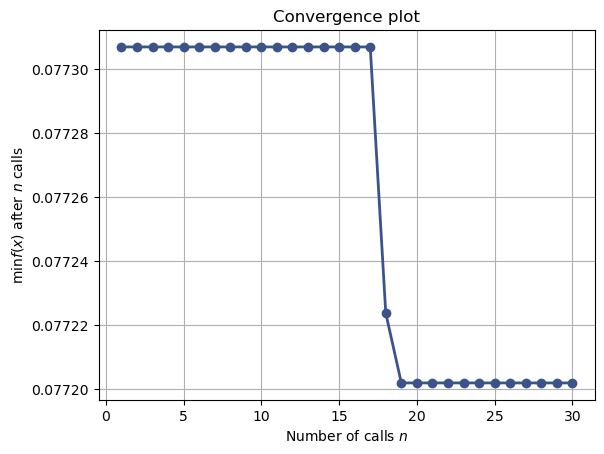

In [104]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Split your data into training and test sets
X_train = baseline_target_train.drop(['y'], axis=1)
y_train = baseline_target_train['y']
X_test = baseline_target.drop(['y'], axis=1)
y_test = baseline_target['y']

space = [
    Real(0.01, 0.3, name='learning_rate'),
    Integer(1, 5, name='max_depth'),
    Integer(1, 50, name='n_estimators'),
    Real(0, 0.5, name='gamma'),
    Real(0.1, 1.0, name='subsample'),
    Real(0.1, 1.0, name='colsample_bytree')
]
@use_named_args(space)
def objective(**params):
    clf = xgboost.XGBClassifier(**params)
    clf.fit(X_train, y_train)  # Train the model on your training data
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Predict probabilities on the test data
    return log_loss(y_test, y_pred_proba)

res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# Print the results
print("Best parameters:")
print(res_gp.x)

print("Best score (log loss):")
print(res_gp.fun)

# Plot
plot_convergence(res_gp)


In [105]:
baseline_target["prediction"] = y_pred

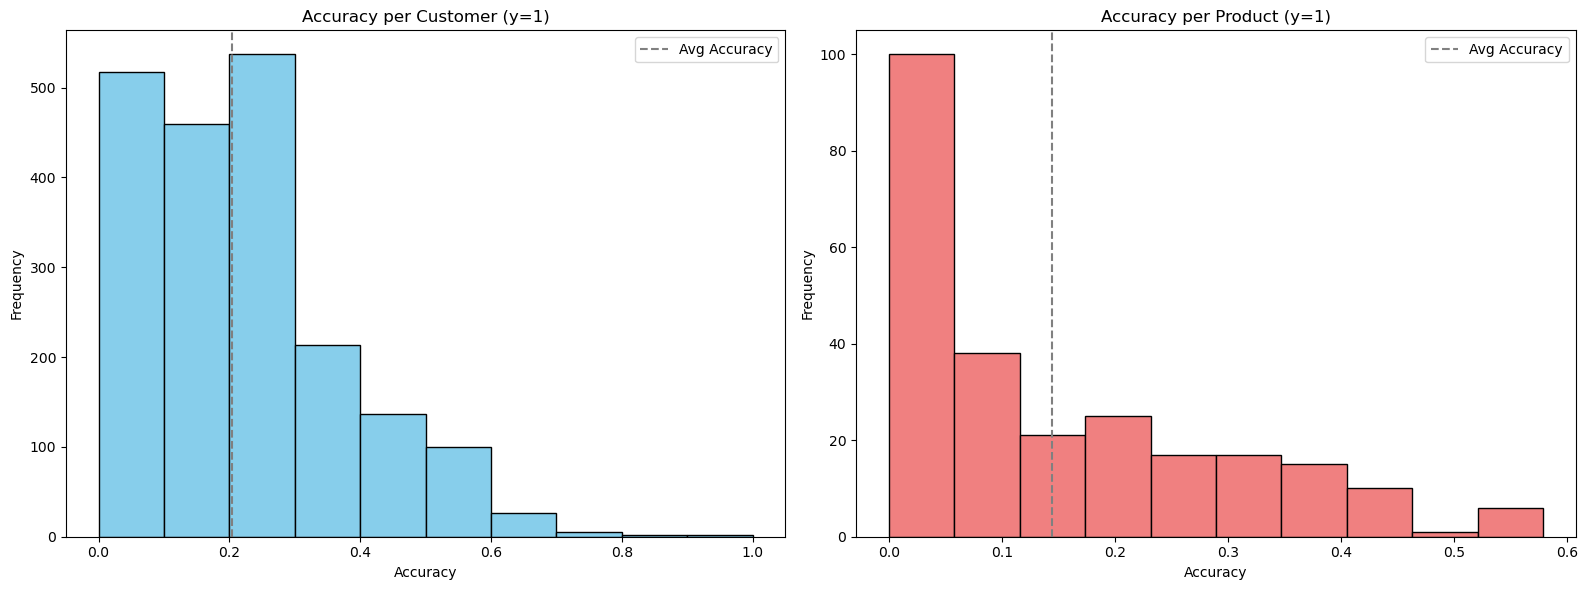

In [106]:


# Filter the data to include only rows where y is 1
filtered_data = baseline_target[baseline_target['y'] == 1]

# Calculate accuracy per customer and per product for y=1
customer_accuracy = filtered_data.groupby('customer').apply(lambda group: accuracy_score(group['y'], group['prediction']))
product_accuracy = filtered_data.groupby('product').apply(lambda group: accuracy_score(group['y'], group['prediction']))

# Calculate the overall average accuracy for y=1
overall_avg_customer_accuracy = customer_accuracy.mean()
overall_avg_product_accuracy = product_accuracy.mean()

# Create a single figure with two subplots in the same row
plt.figure(figsize=(16, 6))

# Subplot 1: Histogram of Accuracy per Customer for y=1
plt.subplot(1, 2, 1)
plt.hist(customer_accuracy, color='skyblue', bins=10, edgecolor='black')
plt.axvline(x=overall_avg_customer_accuracy, color='gray', linestyle='--', label='Avg Accuracy')
plt.title('Accuracy per Customer (y=1)')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

# Subplot 2: Histogram of Accuracy per Product for y=1
plt.subplot(1, 2, 2)
plt.hist(product_accuracy, color='lightcoral', bins=10, edgecolor='black')
plt.axvline(x=overall_avg_product_accuracy, color='gray', linestyle='--', label='Avg Accuracy')
plt.title('Accuracy per Product (y=1)')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

# Adjust subplot spacing
plt.tight_layout()

# Show the figure
plt.show()


In [107]:
pred["probability"] = y_pred_proba

In [108]:
pred.to_parquet("Assignment_2_3_predictions.parquet")